<a href="https://colab.research.google.com/github/ziadelsharawy/Test/blob/main/Cat_and_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cat-and-dog:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F23777%2F30378%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240810%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240810T171258Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D19cb36e8313cac38bf76ccb76aeeaff1bd3de2a01e82eb75e1e287b38562d6f0c05cbf79e49f8b172e6eb8a8782eab411fb64d182f8d5f1e5fa466f5937e18eabf559b6d6e64f8f30ce118d024cfc27012b27bec781a9a55ed0db74d22a17a85aeadf104fefa9d45a667f19c46e2e9a3de2261699ebd592e5231d686aa92f3475f51a9019e021f7dc74d3aa2e6980097c64fcae97111993373dddebde1debe6de28f5717b87ee774b73099d23de5820886db6c00504c13676de7b777b13000146b7212ed53180e03d31753e8d5d2240aeec2c7fd1ef122c4c60e485afbdf8b5b477d5ae2a058bc644bd86153b4c8f50b3d1cbe7f9ce9135ad2012147eba33691'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import os
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,ReLU
import tensorflow as tf
from tensorflow.keras.regularizers import l2


2024-08-10 16:33:34.778505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 16:33:34.778618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 16:33:34.908580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Define directories
train_dir =r'/kaggle/input/cat-and-dog/training_set/training_set'
test_dir =r'/kaggle/input/cat-and-dog/test_set/test_set'
CATOGRY=['cats','dogs']


In [ ]:
ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg', 'bmp', 'tiff'}
Image_Size=128

def is_image_file(filename):
    return filename.lower().split('.')[-1] in ALLOWED_EXTENSIONS

df = []

for category in CATOGRY:
    folder = os.path.join(train_dir, category)
    label = CATOGRY.index(category)
    for imge in os.listdir(folder):
        if not is_image_file(imge):
            continue
        imge_path = os.path.join(folder, imge)
        imge_arr = cv2.imread(imge_path)

        if imge_arr is not None:
            imge_arr = cv2.resize(imge_arr, (Image_Size, Image_Size))
            image = imge_arr / 255.0
            df.append([image, label])
        else:
            print(f"Warning: Unable to read image {imge_path}")

In [ ]:
len(df)

8005

In [ ]:
random.shuffle(df)

In [ ]:
X=[]
y=[]
for features ,labels in df :
    X.append(features)
    y.append(labels)

In [ ]:
X=np.array(X)
y=np.array(y)

In [ ]:
len(X),len(y)

(8005, 8005)

In [ ]:
X.shape

(8005, 128, 128, 3)

In [ ]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

# Print shapes
print(X_train.shape, X_validate.shape)
print(y_train.shape, y_validate.shape)

(6404, 128, 128, 3) (1601, 128, 128, 3)
(6404,) (1601,)


In [ ]:
vani_model = Sequential()
vani_model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same', input_shape = (128,128,3)))
vani_model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
vani_model.add(Dropout(0.4))

vani_model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

vani_model.add(Dropout(0.3))

vani_model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))

vani_model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))


vani_model.add(Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))


vani_model.add(Flatten())

vani_model.add(Dense(512, activation = 'relu'))

vani_model.add(Dropout(0.5))

vani_model.add(Dense(1, activation = 'sigmoid'))


lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, mode='min')

vani_model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 531,185 (2.03 MB)

 Trainable params: 531,185 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
loss = 'binary_crossentropy'
opt = tf.keras.optimizers.Adam(learning_rate= 0.0001,beta_1=0.9, beta_2=0.999,epsilon=1e-07)
metrics = ['accuracy']

vani_model.compile(loss = loss, optimizer = opt, metrics = metrics)
history = vani_model.fit(
    X_train, y_train,
    epochs=25,
    validation_data=(X_validate, y_validate),
    batch_size=32
)

Epoch 1/25


2024-08-10 16:34:39.736768: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32768: 4.46997, expected 3.81534
2024-08-10 16:34:39.736829: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32772: 5.06591, expected 4.41129
2024-08-10 16:34:39.736838: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32773: 5.11251, expected 4.45789
2024-08-10 16:34:39.736846: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32774: 5.4714, expected 4.81678
2024-08-10 16:34:39.736854: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32775: 4.55786, expected 3.90324
2024-08-10 16:34:39.736861: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32776: 4.24873, expected 3.59411
2024-08-10 16:34:39.736869: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32777: 4.63164, expected 3.97701
2024-08-10 16:34:39.736877: 

  5/201 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.4898 - loss: 0.6899 

I0000 00:00:1723307690.708049     308 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


199/201 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5058 - loss: 0.6970

2024-08-10 16:35:00.521533: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.43649, expected 3.49091
2024-08-10 16:35:00.521590: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.77778, expected 5.8322
2024-08-10 16:35:00.521606: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.89882, expected 4.95324
2024-08-10 16:35:00.521624: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.67409, expected 4.72851
2024-08-10 16:35:00.521637: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.06312, expected 4.11754
2024-08-10 16:35:00.521651: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.77568, expected 3.8301
2024-08-10 16:35:00.521668: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.53639, expected 3.59081
2024-08-10 16:35:00.521679: E external/local_xla/xla/serv

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5059 - loss: 0.6970

2024-08-10 16:35:07.882831: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16392: 3.61406, expected 3.06209
2024-08-10 16:35:07.882888: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16393: 4.35648, expected 3.80452
2024-08-10 16:35:07.882898: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16464: 3.8092, expected 3.25724
2024-08-10 16:35:07.882906: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16511: 4.18801, expected 3.63605
2024-08-10 16:35:07.882916: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16895: 4.16274, expected 3.61078
2024-08-10 16:35:07.882925: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 17151: 4.00765, expected 3.45569
2024-08-10 16:35:07.882933: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 17199: 4.38816, expected 3.8362
2024-08-10 16:35:07.882941: E

201/201 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.5059 - loss: 0.6970 - val_accuracy: 0.5946 - val_loss: 0.6904
Epoch 2/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.5335 - loss: 0.6909 - val_accuracy: 0.6077 - val_loss: 0.6783
Epoch 3/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.5615 - loss: 0.6798 - val_accuracy: 0.5540 - val_loss: 0.6749
Epoch 4/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.5855 - loss: 0.6718 - val_accuracy: 0.6246 - val_loss: 0.6465
Epoch 5/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6279 - loss: 0.6468 - val_accuracy: 0.6496 - val_loss: 0.6274
Epoch 6/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6307 - loss: 0.6303 - val_accuracy: 0.6590 - val_loss: 0.6165
Epoch 7/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6628 - loss: 0.6161 - val_accuracy: 0.6927 - val_loss: 0.5885
Epoch 8/25
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6875 - loss: 0.5875 - val_accuracy: 0.66

In [ ]:
loss, accuracy = vani_model.evaluate(X_validate, y_validate, batch_size=32)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7952 - loss: 0.4539
Validation Loss: 0.4603
Validation Accuracy: 0.7970


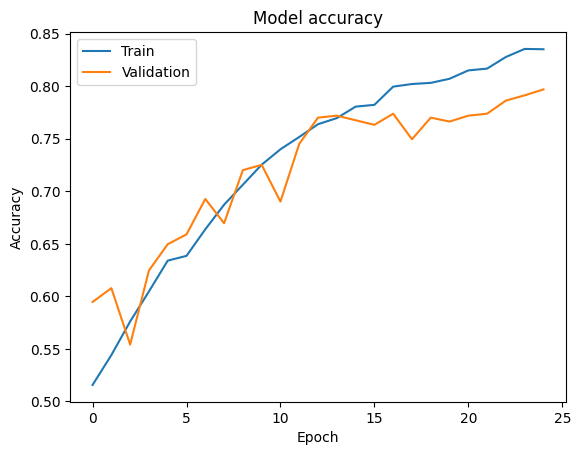

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

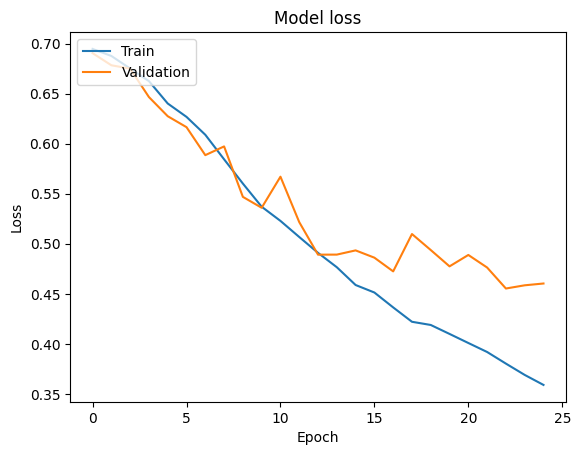

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Class: Dog


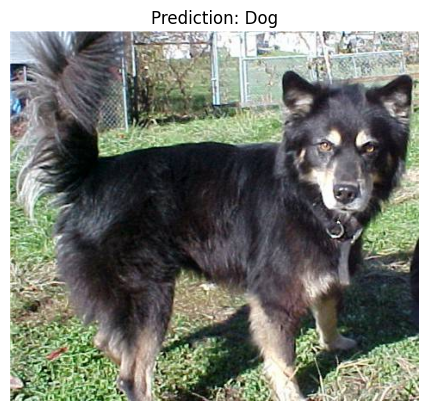

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def preprocess_image(img_path, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def display_image_with_prediction(img_path, prediction):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f'Prediction: {"Cat" if prediction[0][0] == 0 else "Dog"}')
    plt.axis('off')
    plt.show()

img_path = "/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4012.jpg"

preprocessed_image = preprocess_image(img_path)

predictions = vani_model.predict(preprocessed_image)

predicted_class = (predictions > 0.5).astype(int)

print(f'Predicted Class: {"Cat" if predicted_class[0][0] == 0 else "Dog"}')

display_image_with_prediction(img_path, predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Class: Cat


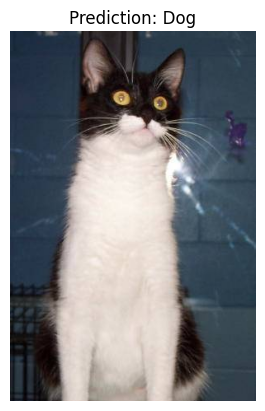

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def preprocess_image(img_path, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def display_image_with_prediction(img_path, prediction):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f'Prediction: {"Cat" if prediction[0][0] == 0 else "Dog"}')
    plt.axis('off')
    plt.show()

img_path = "/kaggle/input/cat-and-dog/test_set/test_set/cats/cat.4146.jpg"

preprocessed_image = preprocess_image(img_path)

predictions = vani_model.predict(preprocessed_image)

predicted_class = (predictions > 0.5).astype(int)

print(f'Predicted Class: {"Cat" if predicted_class[0][0] == 0 else "Dog"}')

display_image_with_prediction(img_path, predictions)


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def preprocess_image(img_path, target_size=(128, 128)):
    """Load and preprocess the image."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def display_image_with_prediction(img_path, prediction):
    """Display the image with its prediction."""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f'Prediction: {"Dog" if prediction[0][0] == 1 else "Not Dog"}')
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Class: Dog


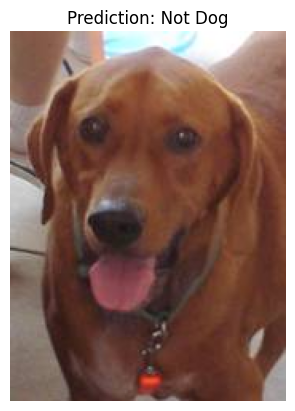

In [ ]:
# Path to your image
img_path = '/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4014.jpg'

# Preprocess the image
preprocessed_image = preprocess_image(img_path)

# Make predictions
predictions = vani_model.predict(preprocessed_image)

# Convert predictions to binary class
predicted_class = (predictions > 0.5).astype(int)

# Determine if the image is a dog
is_dog = predicted_class[0][0] == 1

# Print the result
print(f'Predicted Class: {"Dog" if is_dog else "Not Dog"}')

# Display the image with the prediction
display_image_with_prediction(img_path, predictions)
